# Plot sea ice classes based on thickness and age

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import intake
import dask
dask.config.set({"array.slicing.split_large_chunks": True}) 

## Retrieve data from nextgems

In [2]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
run = cat["FESOM"]['IFS_4.4-FESOM_5-cycle3']

data_thermo_h = run['2D_1h_native'].to_dask()
data_dynam = run['2D_daily_native'].to_dask()

In [3]:
# coordinates
grid = cat["FESOM"]["IFS_4.4-FESOM_5-cycle3"].node_grid.to_dask()
lon_fesom = grid.grid_center_lon.values
lat_fesom = grid.grid_center_lat.values

## Some plot settings/functions
Source: https://nordicesmhub.github.io/NEGI-Abisko-2019/training/example_NorthPolarStereo_projection.html

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cy
from matplotlib import cm
import matplotlib.path as mpath

def add_map_features(ax):
    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS)
    gl = ax.gridlines()#draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey'))

def polarCentral_set_latlim(lat_lims, ax):
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], ccrs.PlateCarree())
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    

## Preprocessing


In [5]:
# temporal downsampling of thermodynamic variables to 
# the temporal resolution of the dynamic variables (from hourly to daily) 
data_thermo = data_thermo_h.sel(time=data_dynam.time)

# create subsets of Arctic and Antarctic region
thermo_arctic = data_thermo.where(data_thermo.lat>=50)
thermo_antarctic = data_thermo.where(data_thermo.lat<=-50)

dynam_arctic = data_dynam.where(data_dynam.lat>=50)
dynam_antarctic = data_dynam.where(data_dynam.lat<=-50)

## Plot ice classes based on thickness

Variable names
- a_ice: sea ice concentration
- m_ice: sea ice thickness [m]


sea ice concentration must be at least 0.15

In [6]:
import matplotlib.lines as mlines

def plot_thickness_classes(
    region='Arctic', 
    date='2024-09-15', 
    thickness_boundary=0.3):
    """_summary_

    Args:
        region (str, optional): either Arctic or Antarctic. Defaults to 'Arctic'. 
        date (str, optional): time snapshot of the region. Defaults to '2024-09-15'.
        thickness_boundary (float, optional): thickness seperating the classes. Defaults to 0.3.
    """
    
    if region == 'Arctic':
        thermo = thermo_arctic
        dynam = dynam_arctic
        projection = ccrs.NorthPolarStereo()
        axis_lims = [50,90]
    elif region == 'Antarctic':
        thermo = thermo_antarctic
        dynam = dynam_antarctic
        projection = ccrs.SouthPolarStereo()
        axis_lims = [-90,-50]
        
    # ---------- get boolean arrays for indexing ---------- 
    # ice concentration at least 0.15
    nodes_a = thermo.a_ice.sel(time=date) >= 0.15
    
    # get grids of ice thickness above 0 and below thickness_boundary
    nodes_m_boundary = (dynam.m_ice.sel(time=date).values > 0 ) & (dynam.m_ice.sel(time=date).values <= thickness_boundary)
    
    # get grids of ice thickness above thickness_boundary
    nodes_m_inf = dynam.m_ice.sel(time=date).values > thickness_boundary

    # unify concentration and thickness conditions
    nodes_boundary = nodes_a & nodes_m_boundary
    nodes_inf = nodes_a & nodes_m_inf
    
    # ---------- some legend settings ---------- 
    legend_boundary = mlines.Line2D([], [], color='salmon', marker='s', linestyle='None',
                          markersize=10, label='thin ice (<='+str(thickness_boundary)+'m)')
    legend_inf = mlines.Line2D([], [], color='lightskyblue', marker='s', linestyle='None',
                          markersize=10, label='thick ice (>'+str(thickness_boundary)+'m)')
    
    # ---------- plot ice classes ---------- 
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121, projection=projection)
    add_map_features(ax1)
    polarCentral_set_latlim(axis_lims, ax1)

    ax1.scatter(
        lon_fesom[nodes_boundary[0]], 
        lat_fesom[nodes_boundary[0]], 
        s=1, 
        c='salmon',
        transform=ccrs.PlateCarree(),
        #label='thin ice (<=0.3m)'
    )

    ax1.scatter(
        lon_fesom[nodes_inf[0]], 
        lat_fesom[nodes_inf[0]], 
        s=1, 
        c='lightskyblue',
        transform=ccrs.PlateCarree(),
        #label='thick ice (>0.3m)'
    )
    ax1.set_title(region + ' ' + date, fontsize=15)
    ax1.gridlines(draw_labels=True)
    ax1.legend(handles=[legend_boundary, legend_inf], loc='center left', bbox_to_anchor=(1,0.5))

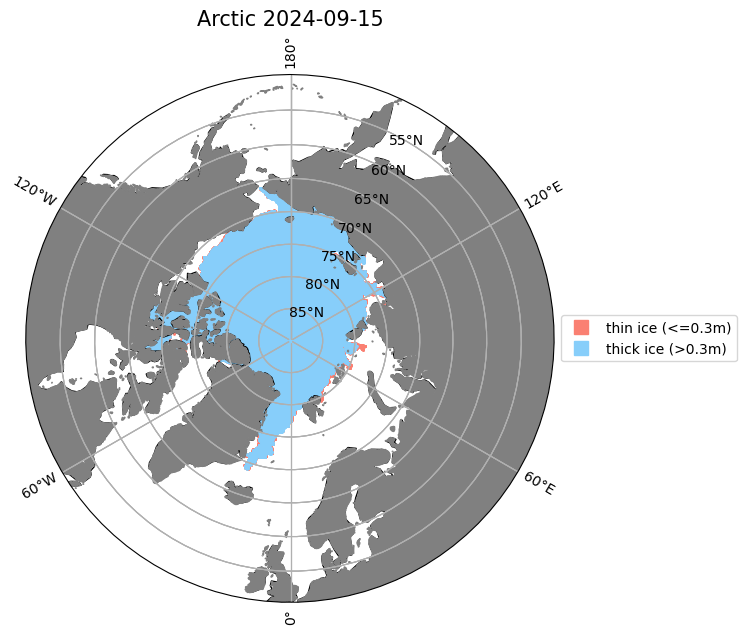

In [7]:
plot_thickness_classes()

other plots besides the default settings

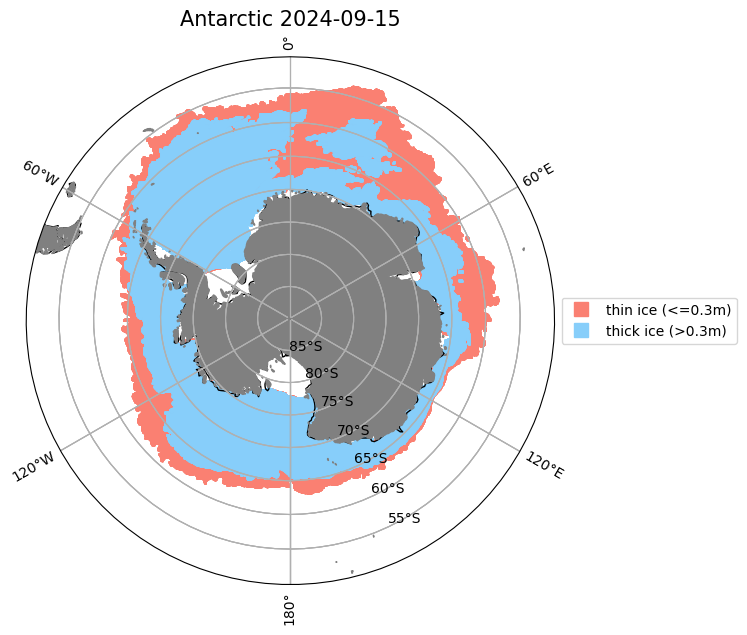

In [8]:
plot_thickness_classes(region='Antarctic')

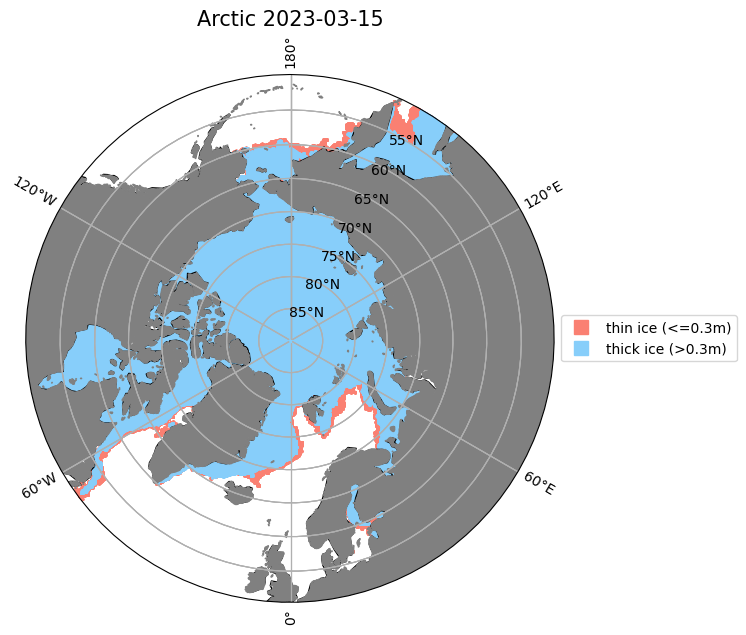

In [9]:
plot_thickness_classes(date='2023-03-15')

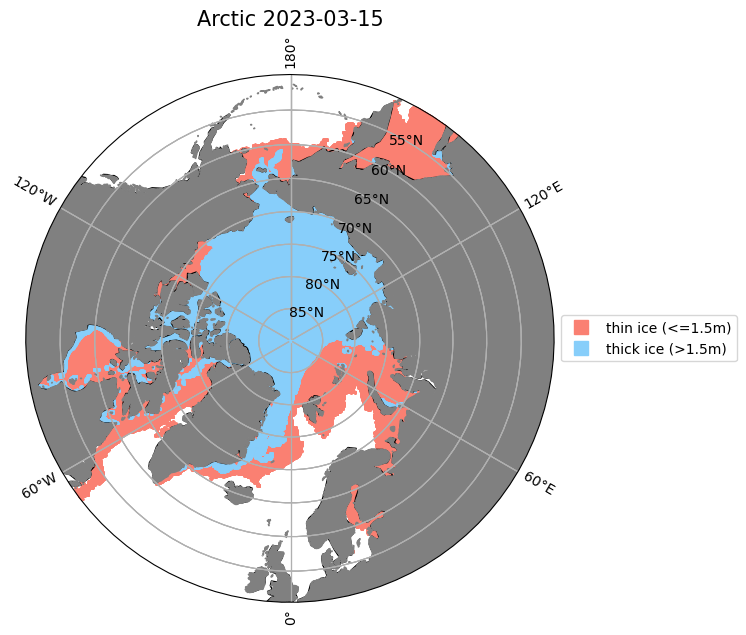

In [10]:
plot_thickness_classes(date='2023-03-15', thickness_boundary=1.5)

## Plot ice categories based on age
Due to computational time, we need to downsample the data spatially and temporally

Classes:
- 0 - 1 year
- 1 - 2 years
- older than 2 years 

ice thickness is not considered

In [43]:

def compute_age_classes(
    region='Arctic', 
    date_end='2023-11-08', 
    step_spatial=100,
    step_temporal=2,
    save_results=False,
    load_results=False,
    ):
    """_summary_

    Args:
        region (str, optional): Either Arctic or Antarctic. Defaults to 'Arctic'. 
        date_end (str, optional): Time snapshot of the region. Defaults to '2024-09-15'.
        step_spatial (int, optional): Spatial downsample step. Defaults to 100.
        step_temporal (int, optional): Temporal downsample step of monthly data. Defaults to 2.
        save_results (bool, optional): Save results of ice classification as csv file. Defaults to False.
        load_results (bool, optional): Load csv file of ice classification if file exists. Defaults to False.

    Returns:
        plot_settings (dict): plot settings including region, date_end, projection and axis_lims 
        df_ice_age_classes (pandas dataframe): results of ice classification with geographic information and node indices of fesom grid
    """
        
    # get the start time of interest, which is 2 years before the date_end, 
    # since we classify the sea ice up to the age of 2 years
    year = int(date_end[:4])
    date_start = str(year-2) + date_end[4:]
    
    # get day of date_end, we group the data according to day 
    # as we only look at monthly data due to computational time
    day = int(date_end[-2:])
    
    if region == 'Arctic':
        thermo = thermo_arctic.groupby('time.day')[day]
        projection = ccrs.NorthPolarStereo()
        axis_lims = [60,90]
    elif region == 'Antarctic':
        thermo = thermo_antarctic.groupby('time.day')[day]
        projection = ccrs.SouthPolarStereo()
        axis_lims = [-90,-50]
        
        
    # ---------- get boolean arrays for indexing ---------- 
    # ice concentration greater than or equal to 0.15
    nodes_a = thermo.a_ice.sel(time=date_end).values >= 0.15

    # get indices (nod2) of true values and downsample to specified spatial step
    idx_true = np.where(nodes_a)[1][::step_spatial]

    # ---------- determine age of sea ice of each node ---------- 
    if not load_results:       
        print('total nodes: ' + str(int(len(idx_true))))
        
        # reverse time and downsample to specified temporal step
        time = thermo.sel(time=slice(date_start, date_end)).time.values[::-1][::step_temporal]

        # preallocate numpy array of ice age classes 
        ice_age_classes = np.zeros(len(idx_true)) * np.nan
        
        print('node: age class')
        
        # this can take ~30 min
        for i in range(len(idx_true)):
            node = thermo.sel(nod2=idx_true[i], time=time)
            
            # get entries where the concentration is below 0.15, hence when sea ice has disappeared
            idx_a = node.a_ice.values < 0.15
            
            # classify node according to age
            if not any(idx_a):
                # if all entries are False, ice is older than 2 years
                ice_age_classes[i] = 2
            else:
                # get first True entry, which corresponds to the time in which sea ice has first disappeared
                # subtract 1 since the sea ice exists until one time step before the first True entry
                age = np.where(idx_a)[0][0] - 1   
                if (age >= 0) & (age < 12/step_temporal):
                    ice_age_classes[i] = 0
                elif (age >= 12/step_temporal) & (age < 24/step_temporal):
                    ice_age_classes[i] = 1
                elif (age >= 24/step_temporal):
                    ice_age_classes[i] = 2
                    
            print(str(i) + ': ' + str(ice_age_classes[i]))
        
        # save results in pandas dataframe    
        df_ice_age_classes = pd.DataFrame(
            data={
                'nod2': thermo.nod2.values[idx_true],
                'lon': thermo.sel(nod2=idx_true).lon.values, 
                'lat': thermo.sel(nod2=idx_true).lat.values, 
                'ice_age_classes': ice_age_classes
            }
        )
        
    plot_settings = {
        "region": region,
        "date_end": date_end,
        "projection": projection,
        "axis_lims": axis_lims,
    }
    
    # save results, csv file will be created        
    if (not load_results) & (save_results):
        df_ice_age_classes.to_csv(date_end + '_age_classes.csv',index=False)

    # load results 
    if load_results:
        df_ice_age_classes = pd.read_csv(date_end + '_ice_age_classes.csv')
    
    return plot_settings, df_ice_age_classes

In [20]:
# compute age of ice with default settings
plot_settings, df_ice_age_classes = compute_age_classes()

total nodes: 3477
node: age class
0: 0.0
1: 0.0
2: 0.0
3: 1.0
4: 0.0
5: 0.0
6: 0.0
7: 0.0
8: 1.0
9: 1.0
10: 1.0
11: 1.0
12: 1.0
13: 1.0
14: 1.0
15: 1.0
16: 1.0
17: 1.0
18: 1.0
19: 1.0
20: 1.0
21: 1.0
22: 1.0
23: 1.0
24: 1.0
25: 1.0
26: 1.0
27: 1.0
28: 1.0
29: 1.0
30: 1.0
31: 1.0
32: 1.0
33: 1.0
34: 1.0
35: 1.0
36: 1.0
37: 1.0
38: 1.0
39: 2.0
40: 1.0
41: 1.0
42: 1.0
43: 1.0
44: 2.0
45: 2.0
46: 2.0
47: 2.0
48: 2.0
49: 2.0
50: 2.0
51: 2.0
52: 2.0
53: 1.0
54: 2.0
55: 1.0
56: 1.0
57: 1.0
58: 1.0
59: 1.0
60: 2.0
61: 2.0
62: 1.0
63: 2.0
64: 2.0
65: 2.0
66: 2.0
67: 2.0
68: 2.0
69: 2.0
70: 2.0
71: 2.0
72: 2.0
73: 2.0
74: 2.0
75: 1.0
76: 2.0
77: 1.0
78: 1.0
79: 1.0
80: 1.0
81: 1.0
82: 1.0
83: 1.0
84: 1.0
85: 1.0
86: 1.0
87: 1.0
88: 1.0
89: 0.0
90: 0.0
91: 1.0
92: 1.0
93: 1.0
94: 1.0
95: 1.0
96: 1.0
97: 1.0
98: 0.0
99: 0.0
100: 0.0
101: 2.0
102: 1.0
103: 2.0
104: 0.0
105: 0.0
106: 0.0
107: 1.0
108: 2.0
109: 2.0
110: 2.0
111: 2.0
112: 2.0
113: 2.0
114: 2.0
115: 2.0
116: 2.0
117: 2.0
118: 2.0
119: 

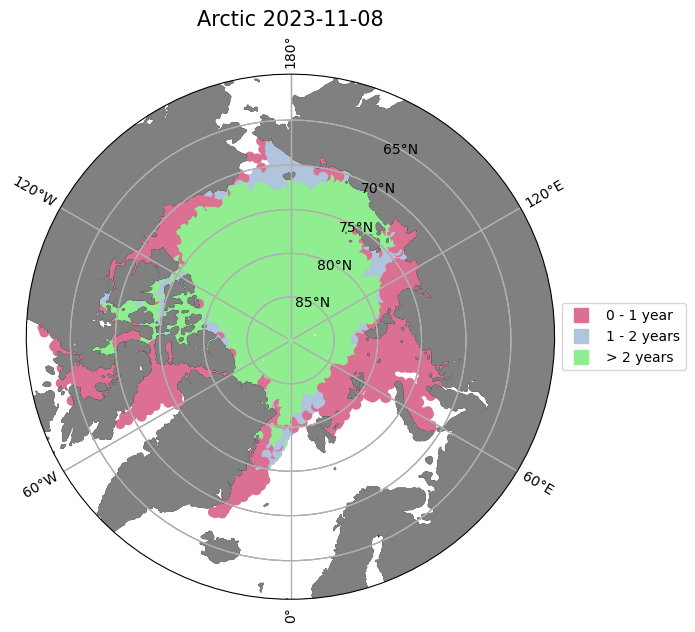

In [45]:
import matplotlib

# ---------- some legend settings ---------- 
cmap = matplotlib.colors.ListedColormap(["palevioletred", "lightsteelblue", "lightgreen"])
young_ice = mlines.Line2D([], [], color='palevioletred', marker='s', linestyle='None',
                        markersize=10, label='0 - 1 year')
oneyear_ice = mlines.Line2D([], [], color='lightsteelblue', marker='s', linestyle='None',
                        markersize=10, label='1 - 2 years')
multiyear_ice = mlines.Line2D([], [], color='lightgreen', marker='s', linestyle='None',
                        markersize=10, label='> 2 years')

# ---------- plot ice classes ---------- 
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection=plot_settings['projection'])
add_map_features(ax1)
polarCentral_set_latlim(plot_settings['axis_lims'], ax1)

ax1.scatter(
    df_ice_age_classes['lon'], 
    df_ice_age_classes['lat'], 
    s=40, 
    c=df_ice_age_classes['ice_age_classes'],
    cmap=cmap,
    transform=ccrs.PlateCarree(),
)
ax1.set_title(plot_settings['region'] + ' ' + plot_settings['date_end'], fontsize=15)
ax1.gridlines(draw_labels=True)
ax1.legend(
    handles=[young_ice, oneyear_ice, multiyear_ice], 
    loc='center left', 
    bbox_to_anchor=(1,0.5)
    )
